In [7]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple

import matplotlib.pyplot as plt

from IPython import display
import imageio

torch.set_default_device('cuda')
device = 'cuda'

In [8]:
# Определение класса Transition для хранения переходов
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Преобразование входных данных в плоский формат
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) * self.action_bound
        return x

# Определение класса Critic
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state, action):
        # Преобразование тензора действия к нужной размерности
        #print(state.shape, action.shape)
        height, width = 96, 96
        #action = action.unsqueeze(1).unsqueeze(2).expand(state.size(0), height, width, -1)
        state = state.view(state.size(0), -1)

        #print(state.shape, action.shape)
        x = torch.cat([state, action], dim=1)
        #print(x.shape)

        #batch_size = x.size(0)
        #num_features = x.size(1) * x.size(2) * x.size(3)
        #x = x.view(num_features, batch_size)

        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Определение буфера воспроизведения для хранения опыта
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        return [self.memory[idx] for idx in indices]

In [9]:
# Создание экземпляра окружения
env = gym.make('CarRacing-v2', render_mode = 'rgb_array')

# Определение параметров
state_dim = 96 * 96 * 3
action_dim = 3
action_bound = 1.0
batch_size = 5
gamma = 0.99
tau = 0.001

# Определение экземпляров сетей Actor и Critic
actor = Actor(state_dim, action_dim, action_bound)
critic = Critic(state_dim, action_dim)

# Создание целевой модели актора и копирование весов из основной модели
target_actor = Actor(state_dim, action_dim, action_bound)
target_actor.load_state_dict(actor.state_dict())  # Инициализация весов как у основной модели актора
target_actor.eval()

target_critic = Critic(state_dim, action_dim)
target_critic.load_state_dict(critic.state_dict())  # Инициализация весов как у основной модели критика
target_critic.eval()

# Определение оптимизаторов
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001)

# Определение буфера воспроизведения
replay_buffer = ReplayBuffer(capacity=10000)

# Обучение
num_episodes = 100
max_steps_per_episode = 50  # Максимальное количество шагов в эпизоде
init_step = 50

In [10]:
for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0

    frames = [env.render()]
    for step in range(init_step):
        env.step([0.,0.,0.])

    for step in range(max_steps_per_episode):
        print("====================================")
        print(f"Step: {step}, Episode: {episode}")

        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            action = actor(state_tensor).squeeze(0)

        print("Original action:", action)
        action = action.cpu().numpy()    
        action = np.clip(action + np.random.normal(0, 0.1), -action_bound, action_bound)
        

        step_info = env.step(action)
        next_state, reward, done = step_info[0], step_info[1], step_info[2]
        frames.append(env.render())

        print(f"Action: {action}, Reward: {episode_reward}, Done: {done}")

        transition = (state, action, next_state, reward, done)
        replay_buffer.push(transition)
        episode_reward += reward

        if len(replay_buffer.memory) > batch_size:
            batch = replay_buffer.sample(batch_size)
            batch = Transition(*zip(*batch))

            state_batch = torch.tensor(batch.state, dtype=torch.float32)
            action_batch = torch.tensor(batch.action, dtype=torch.float32)
            next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
            done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)

            with torch.no_grad():
                target_action_next = target_actor(next_state_batch)
                target_q_next = target_critic(next_state_batch, target_action_next)
                target_q = reward_batch + gamma * (1.0 - done_batch) * target_q_next

            critic_loss = F.mse_loss(critic(state_batch, action_batch), target_q)
            print(f"Critic loss: {critic_loss.item()}, Step: {step}, Episode: {episode}")

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            predicted_action = actor(state_batch)
            actor_loss = -critic(state_batch, predicted_action).mean()

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

        state = next_state
        if done:
            print("Done")
            print(f"Episode: {episode + 1}, Reward: {episode_reward}")
            break

# Закрытие среды
env.close()

torch.save(actor.state_dict(), 'actor_model.pth')
torch.save(critic.state_dict(), 'critic_model.pth')

/users/eleves-b/2021/polina.ovsiannikova/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Step: 0, Episode: 0
Original action: tensor([-0.8603,  0.9792, -0.5171], device='cuda:0')
Action: [-0.7679928   1.         -0.42473304], Reward: 0, Done: False
Step: 1, Episode: 0
Original action: tensor([-0.9055,  0.9792, -0.8772], device='cuda:0')
Action: [-0.8340193   1.         -0.80574596], Reward: -0.10000000000000009, Done: False
Step: 2, Episode: 0
Original action: tensor([-0.8920,  0.9501, -0.8941], device='cuda:0')
Action: [-0.796273   1.        -0.7983603], Reward: -0.20000000000000018, Done: False
Step: 3, Episode: 0
Original action: tensor([-0.8460,  0.9769, -0.7818], device='cuda:0')
Action: [-0.8780932   0.94487315 -0.81387943], Reward: -0.30000000000000027, Done: False
Step: 4, Episode: 0
Original action: tensor([-0.8956,  0.9658, -0.6653], device='cuda:0')
Action: [-0.9495202   0.91188717 -0.71927047], Reward: -0.40000000000000036, Done: False
Step: 5, Episode: 0
Original action: tensor([-0.9776,  0.9270, -0.6092], device='cuda:0')
Action: [-1.          0.8100283  -0.7

In [ ]:
len(frames)

51

TypeError: Image data of dtype object cannot be converted to float

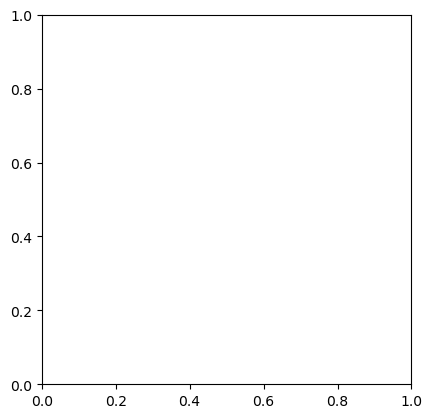

In [ ]:
img = plt.imshow(frames[0])
for frame in frames:
    img.set_data(frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)

imageio.mimsave('test.gif', frames)